# *(Brette, et, al., 2007)* CUBA

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/examples/blob/main/ei_nets/Brette_2007_CUBA.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/examples/blob/main/ei_nets/Brette_2007_CUBA.ipynb)

Implementation of the paper:

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98

which is based on the balanced network proposed by:

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95

Authors:

- [Chaoming Wang](https://github.com/chaoming0625)

In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np

bp.math.set_platform('cpu')

In [2]:
bp.__version__

'2.4.4.post1'

## Old version

In [3]:
class CUBA(bp.DynSysGroup):
  def __init__(self, scale=1.0, method='exp_auto'):
    # network size
    num_exc = int(3200 * scale)
    num_inh = int(800 * scale)

    # neurons
    pars = dict(V_rest=-49, V_th=-50., V_reset=-60, tau=20., tau_ref=5.,
                V_initializer=bp.init.Normal(-55., 2.))
    E = bp.neurons.LIF(num_exc, **pars, method=method)
    I = bp.neurons.LIF(num_inh, **pars, method=method)

    # synapses
    we = 1.62 / scale  # excitatory synaptic weight (voltage)
    wi = -9.0 / scale  # inhibitory synaptic weight
    E2E = bp.synapses.Exponential(E, E, bp.conn.FixedProb(0.02),
                                  g_max=we, tau=5., method=method)
    E2I = bp.synapses.Exponential(E, I, bp.conn.FixedProb(0.02),
                                  g_max=we, tau=5., method=method)
    I2E = bp.synapses.Exponential(I, E, bp.conn.FixedProb(0.02),
                                  g_max=wi, tau=10., method=method)
    I2I = bp.synapses.Exponential(I, I, bp.conn.FixedProb(0.02),
                                  g_max=wi, tau=10., method=method)

    super(CUBA, self).__init__(E2E, E2I, I2E, I2I, E=E, I=I)

In [4]:
# network
net = CUBA()

In [5]:
# simulation
runner = bp.DSRunner(net,
                     monitors=['E.spike'],
                     inputs=[('E.input', 20.), ('I.input', 20.)])
runner.run(100.)

  0%|          | 0/1000 [00:00<?, ?it/s]

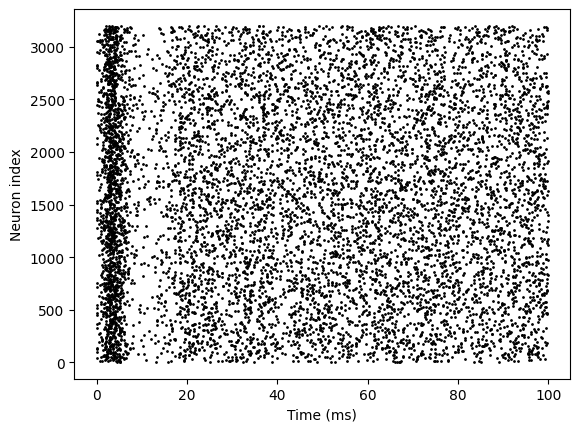

In [6]:
# visualization
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=True)

## New version (>= 2.4.0)

In [7]:
class ExponCUBA(bp.Projection):
    def __init__(self, pre, post, prob, g_max, tau):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPostMg2(
            pre=pre,
            delay=None, 
            comm=bp.dnn.EventCSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
            syn=bp.dyn.Expon.desc(post.num, tau=tau),
            out=bp.dyn.CUBA.desc(),
            post=post,
        )

In [8]:
class CUBA_Net(bp.DynSysGroup):
  def __init__(self, scale=1.0):
    super().__init__()
      
    # network size
    num_exc = int(3200 * scale)
    num_inh = int(800 * scale)

    # neurons
    pars = dict(V_rest=-49, V_th=-50., V_reset=-60, tau=20., tau_ref=5.,
                V_initializer=bp.init.Normal(-55., 2.))
    self.E = bp.dyn.LifRef(num_exc, **pars)
    self.I = bp.dyn.LifRef(num_inh, **pars)

    # synapses
    we = 1.62 / scale  # excitatory synaptic weight (voltage)
    wi = -9.0 / scale  # inhibitory synaptic weight
    self.E2E = ExponCUBA(self.E, self.E, 0.02, g_max=we, tau=5.)
    self.E2I = ExponCUBA(self.E, self.I, 0.02, g_max=we, tau=5.)
    self.I2E = ExponCUBA(self.I, self.E, 0.02, g_max=wi, tau=10.)
    self.I2I = ExponCUBA(self.I, self.I, 0.02, g_max=wi, tau=10.)
    
  def update(self, inp):
      self.E2E()
      self.E2I()
      self.I2E()
      self.I2I()
      self.E(inp)
      self.I(inp)
      return self.E.spike, self.I.spike

In [9]:
# network
net = CUBA_Net()

In [10]:
# simulation
indices = np.arange(1000)  # duration 100 ms
e_sps, i_sps = bp.math.for_loop(lambda i: net.step_run(i, 20.), indices, progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

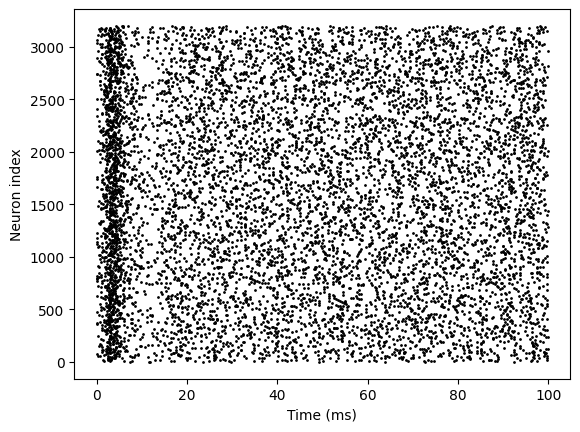

In [11]:
# visualization
bp.visualize.raster_plot(indices * bm.get_dt(), e_sps, show=True)